In [1]:
# !pip install pandas matplotlib numpy

In [ ]:
import os
from pathlib import Path
from tabulate import tabulate

from plotter import *
from plotter.epochstats import EpochStats
from plotter.plotepochstats import PlotRangeQueryStats, PlotEpochStats, plot_total_data_movement
from plotter.plotselectivities import PlotSelectivities, PlotSelectivitiesRangeQuery
from plotter.utils import vanilla_dirname, rqdc_dirname
from plotter.dataclass import TABLE_DATA, Metric

PROJECT_DIR = Path.cwd().parent.parent

['Column Family Name: default, Size: 1581334646 bytes, Files Count: 426', 'Level Stats:', 'Level: 0, Files: 0, Size: 0 bytes', 'Level: 1, Files: 10, Size: 38833058 bytes', 'Level: 2, Files: 104, Size: 417829579 bytes', 'Level: 3, Files: 312, Size: 1124672009 bytes', 'Level: 4, Files: 0, Size: 0 bytes', 'Level: 5, Files: 0, Size: 0 bytes', 'Level: 6, Files: 0, Size: 0 bytes', 'Level: 7, Files: 0, Size: 0 bytes', 'Level: 8, Files: 0, Size: 0 bytes', 'Level: 9, Files: 0, Size: 0 bytes', 'Level: 10, Files: 0, Size: 0 bytes', 'Level: 11, Files: 0, Size: 0 bytes', 'Level: 12, Files: 0, Size: 0 bytes', 'Level: 13, Files: 0, Size: 0 bytes', 'Level: 14, Files: 0, Size: 0 bytes', 'Level: 15, Files: 0, Size: 0 bytes', 'Level: 16, Files: 0, Size: 0 bytes', 'Level: 17, Files: 0, Size: 0 bytes', 'Level: 18, Files: 0, Size: 0 bytes', 'Level: 19, Files: 0, Size: 0 bytes', '', 'RocksDB Statistics:', 'rocksdb.compact.read.bytes: 46434599198', 'rocksdb.compact.write.bytes: 44965050880', 'rocksdb.flush.wr

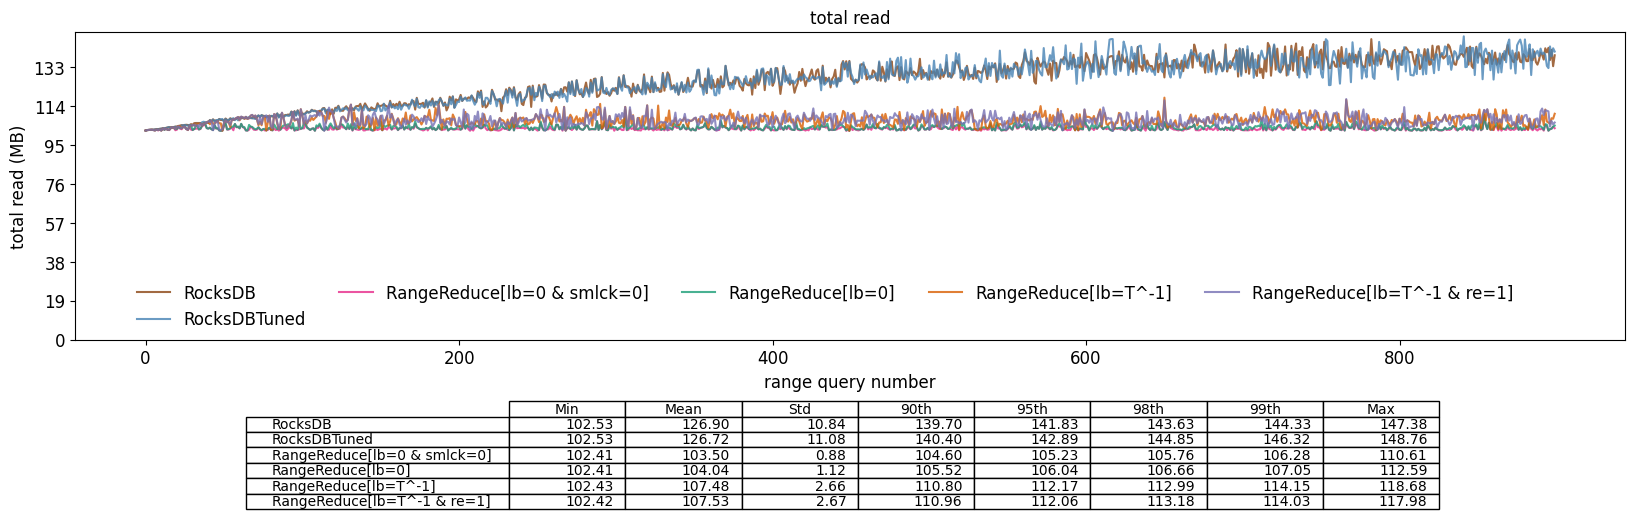

RocksDB 921.1139680322223
RocksDBTuned 0.003066828422776504
RangeReduce[lb=0 & smlck=0] 0.7112580967856783
RangeReduce[lb=0] 0.3142572082446503
RangeReduce[lb=T^-1] 0.02764603006129693
RangeReduce[lb=T^-1 & re=1] 0.010024023047115244
RocksDB 1115.791824
RocksDBTuned -0.008091364738302687
RangeReduce[lb=0 & smlck=0] 0.5951668192448792
RangeReduce[lb=0] 0.5086076788395928
RangeReduce[lb=T^-1] 0.5493416301232169
RangeReduce[lb=T^-1 & re=1] 0.5158446704747393
RocksDB 1443.65213
RocksDBTuned -0.10791623464026615
RangeReduce[lb=0 & smlck=0] 0.5332523920474911
RangeReduce[lb=0] 0.4238291992092784
RangeReduce[lb=T^-1] 0.43247040776901174
RangeReduce[lb=T^-1 & re=1] 0.45683895670573565


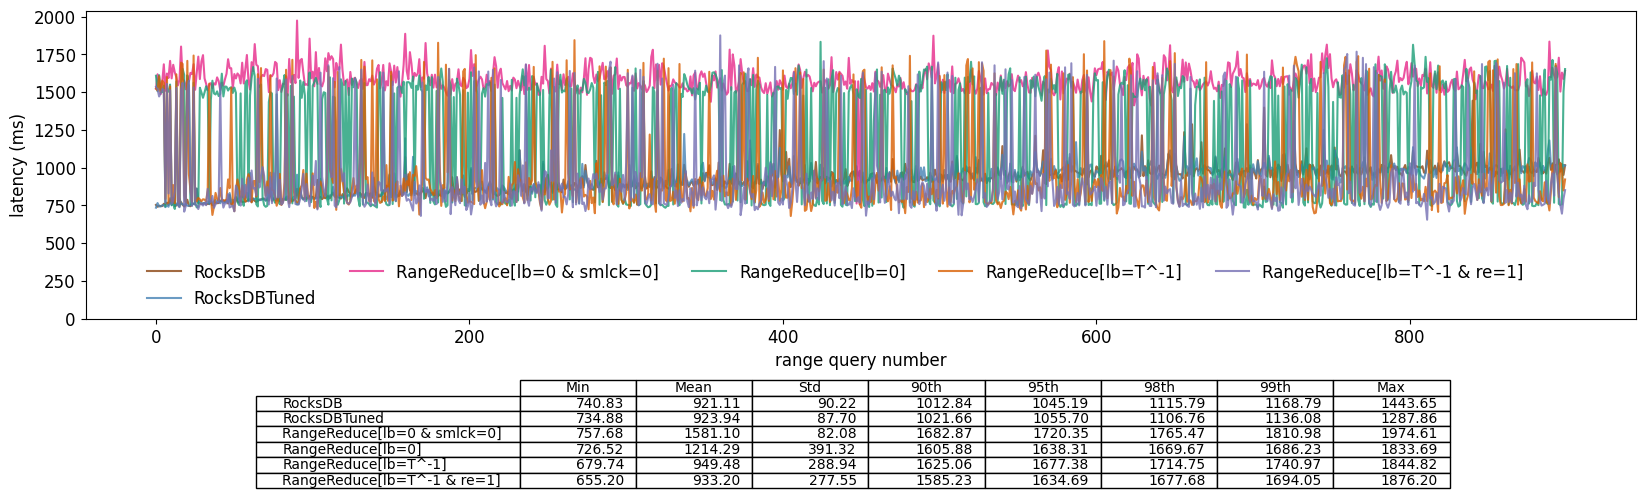

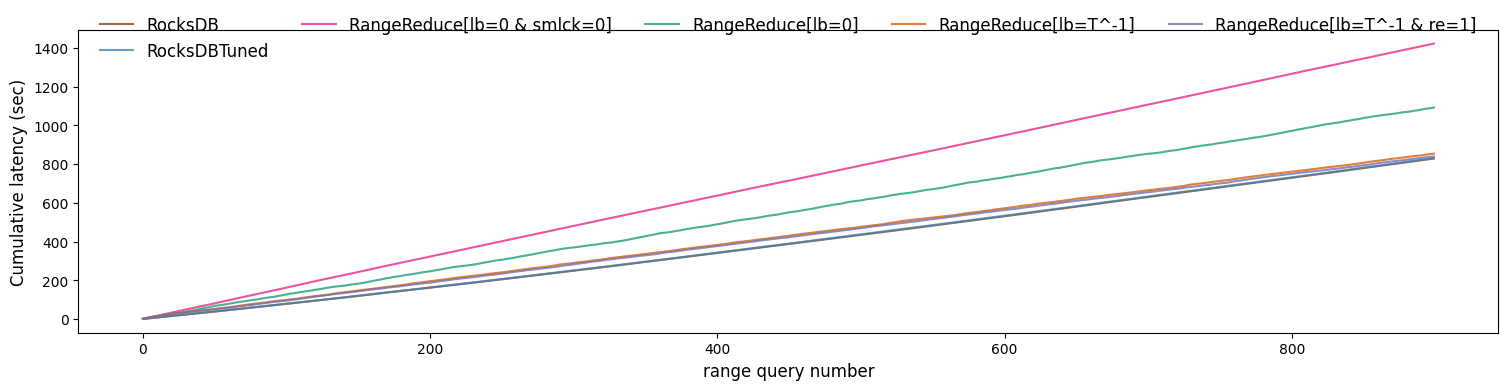

{'RocksDB': {'RR Triggered Count': 0, 'Average Bytes Read RQ (MB)': 126.9, 'RQ Latency (avg ms)': 921.11, 'Tail RQ Latency 98': 1115.79, 'Tail RQ Latency 100': 1443.65}, 'RocksDBTuned': {'RR Triggered Count': 0, 'Average Bytes Read RQ (MB)': '-0.14%', 'RQ Latency (avg ms)': '0.31%', 'Tail RQ Latency 98': '-0.81%', 'Tail RQ Latency 100': '-10.79%'}, 'RangeReduce[lb=0 & smlck=0]': {'RR Triggered Count': 898, 'Average Bytes Read RQ (MB)': '-18.33%', 'RQ Latency (avg ms)': '71.13%', 'Tail RQ Latency 98': '59.52%', 'Tail RQ Latency 100': '53.33%'}, 'RangeReduce[lb=0]': {'RR Triggered Count': 513, 'Average Bytes Read RQ (MB)': '-17.9%', 'RQ Latency (avg ms)': '31.43%', 'Tail RQ Latency 98': '50.86%', 'Tail RQ Latency 100': '42.38%'}, 'RangeReduce[lb=T^-1]': {'RR Triggered Count': 612, 'Average Bytes Read RQ (MB)': '-15.19%', 'RQ Latency (avg ms)': '2.76%', 'Tail RQ Latency 98': '54.93%', 'Tail RQ Latency 100': '43.25%'}, 'RangeReduce[lb=T^-1 & re=1]': {'RR Triggered Count': 609, 'Average Byt

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:180: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


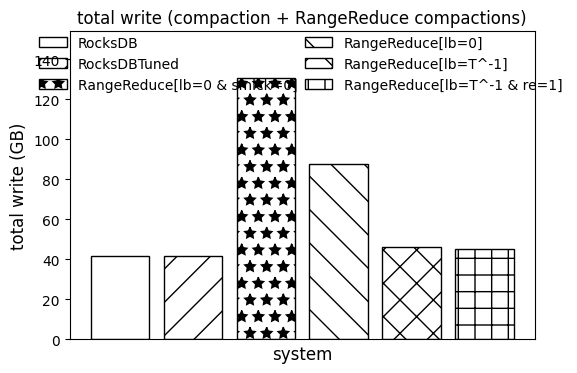

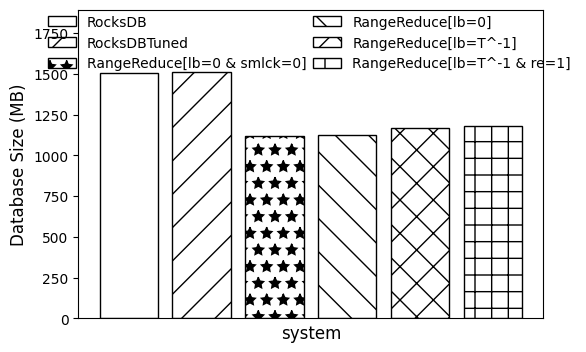

RocksDB 435.5074281692505
RocksDBTuned 0.006952716825834823
RangeReduce[lb=0 & smlck=0] -0.9303466066742512
RangeReduce[lb=0] -0.9328378335622398
RangeReduce[lb=T^-1] -0.8548758540956722
RangeReduce[lb=T^-1 & re=1] -0.8333960572778895


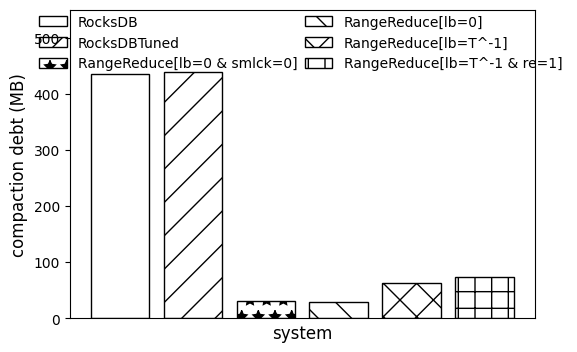

RocksDB 1.4727326538413763
RocksDBTuned 0.002260845931026291
RangeReduce[lb=0 & smlck=0] -0.2577735496367049
RangeReduce[lb=0] -0.25371477291641453
RangeReduce[lb=T^-1] -0.22609317577568136
RangeReduce[lb=T^-1 & re=1] -0.2204938937219014


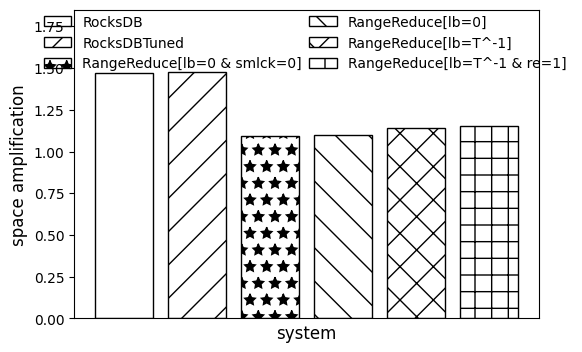

RocksDB 43.245590476319194
RocksDBTuned -0.0019435559380016597
RangeReduce[lb=0 & smlck=0] -0.28340650186657007
RangeReduce[lb=0] -0.2855074650905527
RangeReduce[lb=T^-1] -0.38530528416652393
RangeReduce[lb=T^-1 & re=1] -0.40668544572967424


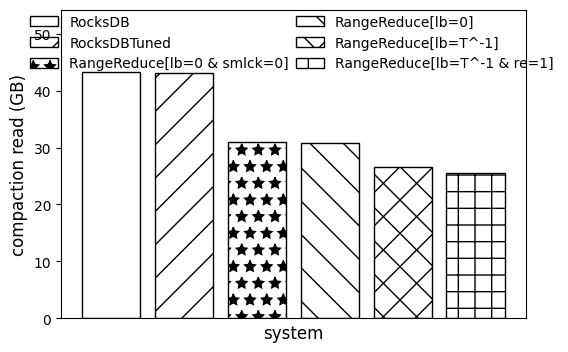

RocksDB 3299.130374802
RocksDBTuned 0.002636188220819217
RangeReduce[lb=0 & smlck=0] 0.16749608371042654
RangeReduce[lb=0] 0.06629950540052684
RangeReduce[lb=T^-1] -0.019318848900869084
RangeReduce[lb=T^-1 & re=1] -0.026009321633808848


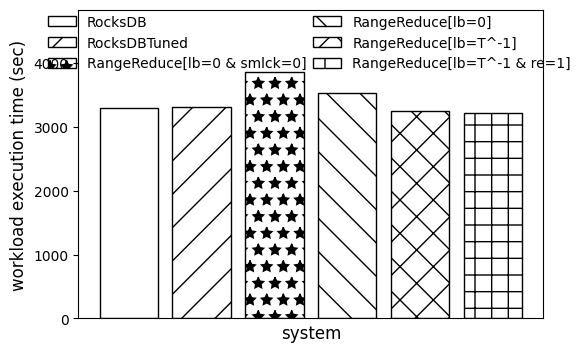

RocksDB 196.65320232324302
RocksDBTuned -0.0016102511535310456
RangeReduce[lb=0 & smlck=0] 0.2852846099043917
RangeReduce[lb=0] 0.06822228707974946
RangeReduce[lb=T^-1] -0.14742332518468768
RangeReduce[lb=T^-1 & re=1] -0.1581120023973261


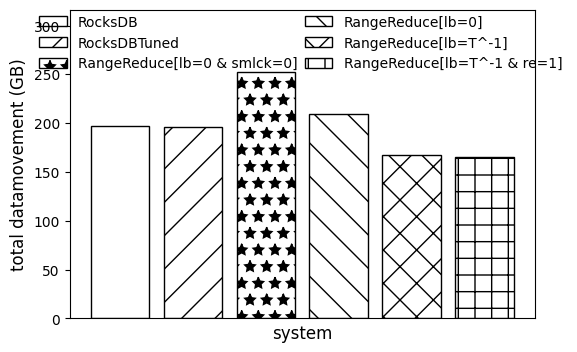

| Method                      |   RR Triggered Count | Average Bytes Read RQ (MB)   | RQ Latency (avg ms)   | Tail RQ Latency 98   | Tail RQ Latency 100   |   Average Bytes Written By RR (MB) | Total Files Count   |   Average File Size | Total Writes (GB)   | Compaction Debt (MB)   | Space Amplification   | Total Compaction Read (Not RR) (GB)   | W/L Execution Time (sec)   | Overall Data Movement (GB)   |
|-----------------------------|----------------------|------------------------------|-----------------------|----------------------|-----------------------|------------------------------------|---------------------|---------------------|---------------------|------------------------|-----------------------|---------------------------------------|----------------------------|------------------------------|
| RocksDB                     |                    0 | 126.9                        | 921.11                | 1115.79              | 1443.65               |                          

In [ ]:
random_rq_stats = dict()
random_rq_stats_for_rq = dict()

lb = 1 / SIZE_RATIO
EXPDIRNAME = f"{PROJECT_DIR}/.vstats/experiments-{TAG}-U{UPDATES}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-S{RANGE_QUERIES}-Y{SELECTIVITY}-T{SIZE_RATIO}"

rocksdb_dirpath = os.path.join(EXPDIRNAME, "RocksDB")
rocksdb_tuned_dirpath = os.path.join(EXPDIRNAME, "RocksDBTuned")
rr_lb0_smlck0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0ANDsmlck=0]")
rr_lb0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0]")
rr_lb_1_by_T_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1]")
rr_lb_1_by_T_and_re_1_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1ANDre=1]")

filesize = ENTRY_SIZE * ENTRIES_PER_PAGE * NUM_PAGE_PER_FILE

rocksdb = EpochStats(rocksdb_dirpath, NUMEPOCHS, filesize)
rocksdb_tuned = EpochStats(rocksdb_tuned_dirpath, NUMEPOCHS, filesize)
rr_lb_0_smlck_0 = EpochStats(rr_lb0_smlck0_dirpath, NUMEPOCHS, filesize)
rr_lb_0 = EpochStats(rr_lb0_dirpath, NUMEPOCHS, filesize)
rr_lb_1_by_T = EpochStats(rr_lb_1_by_T_dirpath, NUMEPOCHS, filesize)
rr_lb_1_by_T_and_re_1 = EpochStats(rr_lb_1_by_T_and_re_1_dirpath, NUMEPOCHS, filesize)

plot_exp = PlotRangeQueryStats(
    {
        "RocksDB": rocksdb.get_rangequerystats(),
        "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
        "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
    }
)
plot_exp.bytes_read_for_each_range_query()
plot_exp.latency_for_each_range_query()
plot_exp.cummulative_latency_for_range_queries()

metric_exp = PlotEpochStats(
    {
        "RocksDB": rocksdb.get_plotstats(),
        "RocksDBTuned": rocksdb_tuned.get_plotstats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
        "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
    }
)
metric_exp.plot_total_bytes_written()
metric_exp.plot_database_size()
metric_exp.plot_compaction_debt()
metric_exp.plot_space_amplification()
metric_exp.plot_compaction_read()
metric_exp.plot_workload_exec_time()
plot_total_data_movement(
    {
        "RocksDB": rocksdb.get_plotstats(),
        "RocksDBTuned": rocksdb_tuned.get_plotstats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
        "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
    },
    {
        "RocksDB": rocksdb.get_rangequerystats(),
        "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
        "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
        "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
        "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
        "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
    },
)

rows = []
ordered_columns = ["Method"] + [metric.value[0] for metric in Metric]

for method, metrics in TABLE_DATA.items():
    row = {"Method": method}
    row.update(metrics)
    rows.append(row)

ordered_rows = []
for row in rows:
    ordered_row = {col: row.get(col, "") for col in ordered_columns}
    ordered_rows.append(ordered_row)

markdown_table = tabulate(ordered_rows, headers="keys", tablefmt="github")
print(markdown_table)